## Import necessary libraries

In [1]:
from paldnn import main
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras.constraints import maxnorm
from tensorflow.keras.models import load_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

C:\Users\ericp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ericp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ericp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ericp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Load PA dataset as dataframe

In [3]:
# Load Dataset
pa_dataset = pd.read_csv('PA_Dataset.csv')

# Sample a subset of the dataset to speed up example
pa_subset = pa_dataset.sample(160)

## Extract PA structure from the database


In [4]:
peptides = [p.strip(' ') for p in pa_subset['Pep Seq']]
Nterm = pa_subset['N-Term SMILES']
Cterm = pa_subset['C-Term SMILES']
pHs = pa_subset['pH']

## Calculate Molecular Descriptors

In [5]:
#### Calculated Hydrophobicity Gradient descriptors
degree = 1 # degree parameter for the HydrophobicityGradients, see documentation for details
data = []
for peptide,pH,Nterm_SMILES,Cterm_SMILES in zip(peptides,pHs,Nterm,Cterm):
    [col_labels, col_val] = main.HydrophobicityGradients(peptide, Nterm_SMILES, Cterm_SMILES, pH, degree)
    data.append(col_val)
df_HG = pd.DataFrame(np.array(data))
df_HG.columns = col_labels

#### Calculate Charge Descriptors
order = 1 # order of autocorrelation functions
data = []
for peptide,pH in zip(peptides,pHs):
    [col_labels, col_val] = main.ChargeDescriptors(peptide, pH, order)
    data.append(col_val)
df_charge = pd.DataFrame(np.array(data))
df_charge.columns = col_labels

#### Calculate Hydrophobicity Descriptors
order = 1 # order of autocorrelation functions
data = []
for peptide,pH in zip(peptides,pHs):
    [col_labels, col_val] = main.HydrophobicityDescriptors(peptide, pH, order)
    data.append(col_val)
df_HD = pd.DataFrame(np.array(data))
df_HD.columns = col_labels

#### Calculate Peptide Descriptors from AAindex
aaindex_dict = main.LoadAAindexDict() # load aaindex parameters from DOI: 10.1093/nar/gkm998
order = 1 # order of autocorrelation functions
data = []
for peptide in peptides:
    [col_labels, col_val] = main.PeptideDescriptors(peptide, order, aaindex_dict)
    data.append(col_val)
df_PD = pd.DataFrame(np.array(data))
df_PD.columns = col_labels

df = pd.concat([df_HG,df_charge,df_HD,df_PD],axis = 1)
df.to_csv('PA_Dataset_Descriptors.csv', index = False)   

## Feature Selection 


In [15]:
X = pd.read_csv('PA_Dataset_Descriptors.csv')
y = to_categorical(pa_subset['Nano Dimension'])

# Remove missing features
X_clean = X.dropna(axis = 1)

# Apply Low Variance Filter
def variance_threshold_selector(data, threshold=0):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

X_filtered = variance_threshold_selector(X_clean)

In [16]:
# Remove Highly Correlated Features
cor_matrix = X_filtered.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_uncorr = X_filtered.drop(to_drop, axis=1)

In [17]:
# Rank most important features determined by random forest
n_forests = 3
f = pd.DataFrame(columns = X_uncorr.columns)

for n in range(n_forests):
    #Create Train and Test Set
    X_train, X_test, y_train, y_test = train_test_split(X_uncorr, y, test_size=0.20)

    #Train Model
    classifier = RandomForestClassifier(n_estimators = 2000, max_depth = 30, max_features = 10)
    classifier.fit(X_train, y_train)

    #Rank Features by Importance
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    labels = list(X_train)
    
    #Save Features
    f = f.append(pd.DataFrame([importances], columns = labels), ignore_index = True)

# Save Top Features
scores =  f.sum(axis = 0)
index = scores.index
order = np.argsort(scores.values)[::-1]

selected_features = [index[i] for i in order]

df = pd.DataFrame(selected_features)
df.columns = ['features']
df.to_csv('PA_Dataset_ranked_features.csv',index = False)

In [18]:
# Select the top ranked features and scale them
num_features = 16 
df = pd.read_csv('PA_Dataset_ranked_features.csv')
selected_features_df = df.iloc[0:num_features]
selected_features = list(selected_features_df['features'])
X_red = X[selected_features]

scaler = StandardScaler()
scaler.fit(X_red);
X_scaled = pd.DataFrame(scaler.transform(X_red), columns = X_red.columns)

## Build Deep Neural Network Model

In [19]:
# Define Model
def DNN_model(x_train, y_train, x_val, y_val, params):

    #Sequential Model 
    model = Sequential()
    model.add(Dense(params['layer 1 nodes'], activation= params['layer 1 activation'],kernel_constraint=maxnorm(params['maxnorm']), input_shape=(x_train.shape[1],)))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['layer 2 nodes'], activation=params['layer 2 activation'],kernel_constraint=maxnorm(params['maxnorm'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(2,activation=params['output activation'])) 
    
    optimizer = optimizers.Adam(learning_rate = params['lr'])
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
   
    es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=params['patience'])
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=[es_callback],
                        verbose=0)
    
    return history, model


## Automated Hyperparameter Tuning

In [20]:
# Create param_grid
p = {'layer 1 nodes' : [8, 16],
          'layer 1 activation': ['relu'],
          'layer 2 nodes': [8, 16],
          'layer 2 activation': ['relu'],
          'output activation': ['sigmoid'],
          'dropout': [0.2],
          'maxnorm': [3],
          'lr': [0.001, 0.01],
          'patience': [32],
          'batch_size': [32],
          'epochs': [500]}

param_grid = list(ParameterGrid(p))

In [21]:
# Search Hyperparameter Space

num_avg = 3
history_list = []
model_list = []

for i in range(len(param_grid)):
    accuracy = []
    history_temp = []
    model_temp = []
    for j in range(num_avg):
        x_train, x_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.40)
        x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50)

        history, model = DNN_model(x_train, y_train, x_val, y_val, param_grid[i])
        history_temp.append(history)
        model_temp.append(model)
        
        #convert y_test to binary classifier
        testy = np.argmax(y_test, axis=-1)
                                   
        # predict probabilities for test set
        yhat_probs = model.predict(x_test, verbose=0)
                                   
        # predict crisp classes for test set
        yhat_classes = model.predict_classes(x_test, verbose=0)
                                   
        # accuracy: (tp + tn) / (p + n)
        accuracy.append(accuracy_score(testy, yhat_classes))

    acc_array = np.array(accuracy)
    best_index = np.argwhere(acc_array == np.max(acc_array))[0][0]
    model_list.append(model_temp[best_index])
    history_list.append(history_temp[best_index])
    
    acc_array = np.array(accuracy)
    param_grid[i]['accuracy'] = np.mean(accuracy)
    param_grid[i]['std'] = np.std(accuracy)


tune_df = pd.DataFrame(param_grid)
tune_df.to_csv('hyperparameter_tuning_results.csv',index = False)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



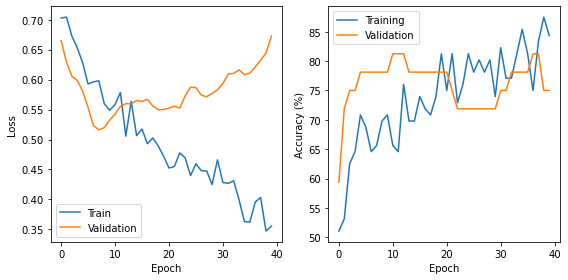

In [31]:
# View Tuned Model and History

# Find optimal hyperparamters
index = tune_df[tune_df['accuracy'] == max(tune_df['accuracy'])].index[0] 
model = model_list[index]
history = history_list[index]

fig, ax = plt.subplots(figsize = (8,4))

# plot loss during training
plt.subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot accuracy during training
plt.subplot(122)
plt.plot(np.array(history.history['accuracy'])*100, label='Training')
plt.plot(np.array(history.history['val_accuracy'])*100, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()

plt.savefig("training_loss_acc.tif", format="tif",bbox_inches='tight')

In [30]:
tune_df[tune_df['accuracy'] == max(tune_df['accuracy'])].index[0]

1